# Chest and breast classification



In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=db223c7318bcd42ae11698789d9226526a87879402afa8e9fc3395ef78e0155f
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt
import medmnist
from medmnist import INFO
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Task 1: 2D breast ultrasound classification.

## Dataloading
We first load a 2D dataset breast ultrasound dataset-BreastMNIST, preprocess it and encapsulate it into dataloader form. Please fill the empty blanks in the following bloacks. You are expected to show the details of training, validation, and test dataset.

In [ ]:
data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True
info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}, 'license': 'CC BY 4.0'}


In [ ]:
"""
Here goes with the hyperparameters for your model.
"""
# hyparameters
BATCH_SIZE =50
EPOCH_NUM =280
lr =0.0001

In [ ]:
"""
Please generate datasets and dataloaders for training, validation, and test dataset.
Datasets should be an object of DataClass and dataloaders should be an object of torch.utils.data.DataLoader.
"""

# preprocessing such as conversion to tensor and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# get the data class
# encapsulate datasets into Dataloader form
DataClass = getattr(medmnist, info['python_class'])

# Load the entire 'train' dataset
train_dataset = DataClass(split='train', transform=transform, download=download)
validation_dataset = DataClass(split='val', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Create data loaders for train and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 559580/559580 [00:00<00:00, 4251676.33it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


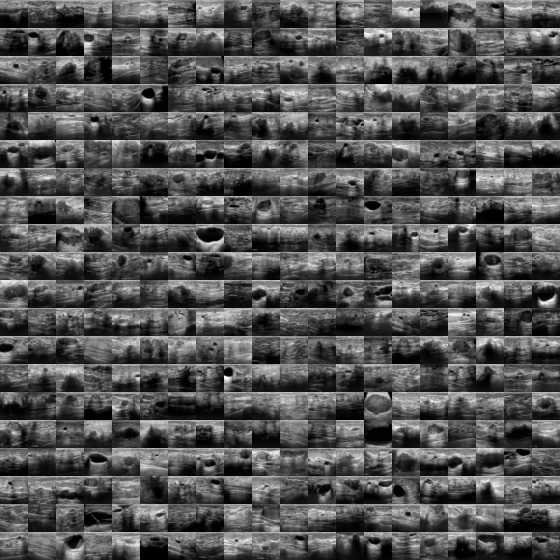

In [ ]:
"""
This block shows the details of the datasets you generated above.
"""
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)

Please fill the blanks in the following block to show the image and its corresponding class label of 2 subjects:
1. the 50th subject in training dataset
2. the 20th subject in test dataset



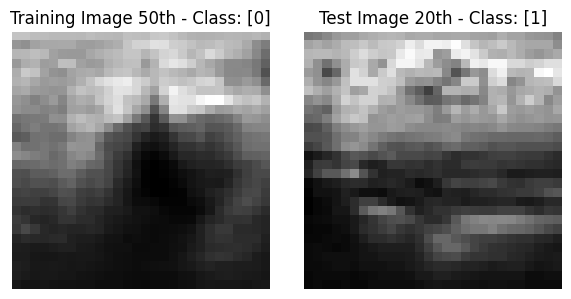

In [ ]:
"""
Please query images and labels and visualize both images with labels as title.
"""
# query images and corresponding labels
im_1, label_1 = train_dataset[49]
im_2, label_2 = test_dataset[19]

# visualization
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(im_1.squeeze(), cmap='gray')
plt.title(f"Training Image 50th - Class: {label_1}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_2.squeeze(), cmap='gray')
plt.title(f"Test Image 20th - Class: {label_2}")
plt.axis('off')

plt.tight_layout()
plt.show()

## Upsampling and downsampling
Upsample the aforementioned subjects with bilinear algorithm from 28$\times$28 to 56$\times$56 and apply a 2D max pooling over the same subjects with kernel size equals 2 and stride equals 2.

**You are expected to use classes implememted in torch.nn.**
*Hit: Pay attention to the dimension of inputs.*


The size of resulted images: torch.Size([56, 56]), torch.Size([56, 56]), torch.Size([14, 14]), torch.Size([14, 14]).


<Figure size 640x480 with 0 Axes>

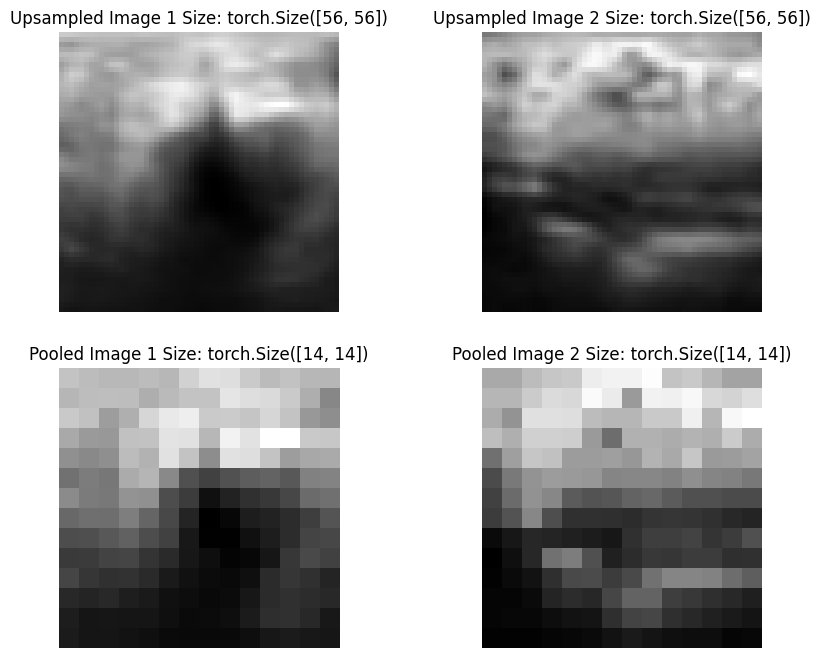

In [ ]:
"""
Please realize upsampling and pooling of target images.
Visualize them with 2*2 subplots and print the size of images.

"""

# upsampling
up_sample = nn.Upsample(size=56, mode='bilinear', align_corners=True)
upsampled_im_1 =up_sample(im_1.unsqueeze(0)).squeeze()
upsampled_im_2 =up_sample(im_2.unsqueeze(0)).squeeze()

# downsampling
pool = nn.MaxPool2d(kernel_size=2, stride=2)
pooled_im_1 =pool(im_1.unsqueeze(0)).squeeze()
pooled_im_2 =pool(im_2.unsqueeze(0)).squeeze()

# visualization
plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(10, 8))

axarr[0, 0].imshow(upsampled_im_1.detach().numpy(), cmap='gray')
axarr[0, 0].set_title(f'Upsampled Image 1 Size: {upsampled_im_1.shape}')
axarr[0, 0].axis('off')

axarr[0, 1].imshow(upsampled_im_2.detach().numpy(), cmap='gray')
axarr[0, 1].set_title(f'Upsampled Image 2 Size: {upsampled_im_2.shape}')
axarr[0, 1].axis('off')

axarr[1, 0].imshow(pooled_im_1.detach().numpy(), cmap='gray')
axarr[1, 0].set_title(f'Pooled Image 1 Size: {pooled_im_1.shape}')
axarr[1, 0].axis('off')

axarr[1, 1].imshow(pooled_im_2.detach().numpy(), cmap='gray')
axarr[1, 1].set_title(f'Pooled Image 2 Size: {pooled_im_2.shape}')
axarr[1, 1].axis('off')

print(f'The size of resulted images: {upsampled_im_1.shape}, {upsampled_im_2.shape}, {pooled_im_1.shape}, {pooled_im_2.shape}.')

## Model implementation

Here you should implement a basic CNN model with 5 convolutional layers. The output layer should be two linear layers. The output activation is sigmoid function.

Define a loss criterion that measures the Binary Cross Entropy between the target and the input probabilities with mean reduction.

In [ ]:
"""
Please design a CNN model. You are execpted to invole batch normalization and pooling.
"""

# define the architecture of the model
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)) # because it's binary classification

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

# initialize your model
cnn_model = CNN(in_channels=n_channels, num_classes=n_classes).to(device)

# define the BCE loss function and an optimizer you prefer
criterion = torch.nn.BCELoss(reduction='mean')
# optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

Here shows the summary of designed CNN architecture.

In [ ]:
"""
Here shows the summary of the model you designed with input size of your data and batch size you chose.
Please pass the size of data size to SAMPLE_DATASIZE.
"""
from torchsummary import summary
# SAMPLE_DATASIZE = im_2.shape
SAMPLE_DATASIZE = im_1.shape


summary(cnn_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [50, 16, 26, 26]             160
       BatchNorm2d-2           [50, 16, 26, 26]              32
              ReLU-3           [50, 16, 26, 26]               0
            Conv2d-4           [50, 16, 24, 24]           2,320
       BatchNorm2d-5           [50, 16, 24, 24]              32
              ReLU-6           [50, 16, 24, 24]               0
         MaxPool2d-7           [50, 16, 12, 12]               0
            Conv2d-8           [50, 64, 10, 10]           9,280
       BatchNorm2d-9           [50, 64, 10, 10]             128
             ReLU-10           [50, 64, 10, 10]               0
           Conv2d-11             [50, 64, 8, 8]          36,928
      BatchNorm2d-12             [50, 64, 8, 8]             128
             ReLU-13             [50, 64, 8, 8]               0
           Conv2d-14             [50, 6

## Training and evaluation

Please fill the blanks in train and test functions.

In [ ]:
"""
Please define functions for training and testing.
- train:
    input: dataloader, model
    output: loss_values for training and validation which is a list containing losses for all epochs.
            trained_model
- test:
    input: dataloader, model
    output: auc, acc
    Please also plot the test ROC curve for each class.
"""
# train and validation
def train(train_loader, model):
    loss_values = []
    val_loss_values = []

    return loss_values, val_loss_values, model

# test
def test(test_loader, model):
    test_loss_values = []

    return auc, acc

In [ ]:
"""
Please define functions for training and testing.
- train:
    input: dataloader, model
    output: loss_values for training and validation which is a list containing losses for all epochs.
            trained_model
- test:
    input: dataloader, model
    output: auc, acc
    Please also plot the test ROC curve for each class.
"""
# train and validation
def train(train_loader, model, optimizer, criterion, EPOCH_NUM, validation_loader):
    loss_values = []
    val_loss_values = []

    for epoch in range(EPOCH_NUM):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the same device
            optimizer.zero_grad()
            # print("inputs shape:", inputs.shape)
            outputs = model(inputs)
            ##
            # print("Output shape:", outputs.shape)
            # print("Label shape:", labels.shape)
            ##
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        # Validation loop
        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)  # Move validation data to the same device
                val_outputs = model(val_inputs)

                val_loss = criterion(val_outputs.float(), val_labels.float())
                val_running_loss += val_loss.item()

            val_epoch_loss = val_running_loss / len(validation_loader)
            val_loss_values.append(val_epoch_loss)

        if epoch % 1 == 0:
            print(f"Epoch [{epoch+1}/{EPOCH_NUM}], Training Loss: {epoch_loss}, Validation Loss: {val_epoch_loss}")

    return loss_values, val_loss_values, model

# test
def test(test_loader, model, criterion):
    test_loss_values = []
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            test_loss_values.append(loss.item())

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    auc = roc_auc_score(actuals, predictions)
    acc = accuracy_score(np.round(predictions), actuals)

    # Plot ROC curve for each class
    fpr, tpr, thresholds = roc_curve(actuals, predictions)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    return auc, acc

Epoch [1/280], Training Loss: 0.6713941584933888, Validation Loss: 0.6922269463539124
Epoch [2/280], Training Loss: 0.6630802967331626, Validation Loss: 0.6891987025737762
Epoch [3/280], Training Loss: 0.6518462300300598, Validation Loss: 0.6750420331954956
Epoch [4/280], Training Loss: 0.6390136209401217, Validation Loss: 0.6532096564769745
Epoch [5/280], Training Loss: 0.6290740316564386, Validation Loss: 0.6346860229969025
Epoch [6/280], Training Loss: 0.6186078136617487, Validation Loss: 0.6200845241546631
Epoch [7/280], Training Loss: 0.6096155914393339, Validation Loss: 0.608348935842514
Epoch [8/280], Training Loss: 0.6013475168835033, Validation Loss: 0.5992522537708282
Epoch [9/280], Training Loss: 0.5932297598231923, Validation Loss: 0.5915882587432861
Epoch [10/280], Training Loss: 0.586185715415261, Validation Loss: 0.5846083760261536
Epoch [11/280], Training Loss: 0.580371921712702, Validation Loss: 0.5783688724040985
Epoch [12/280], Training Loss: 0.5738167681477286, Vali

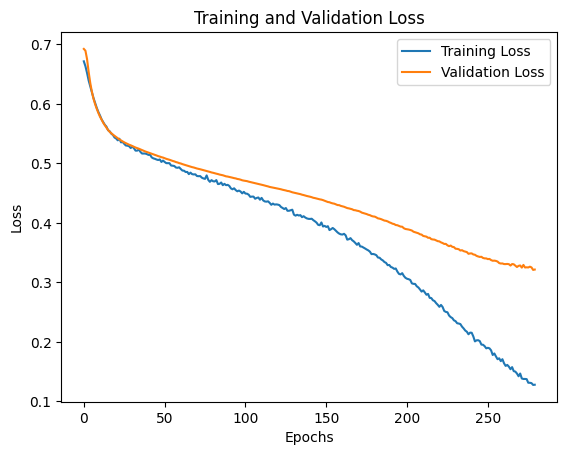

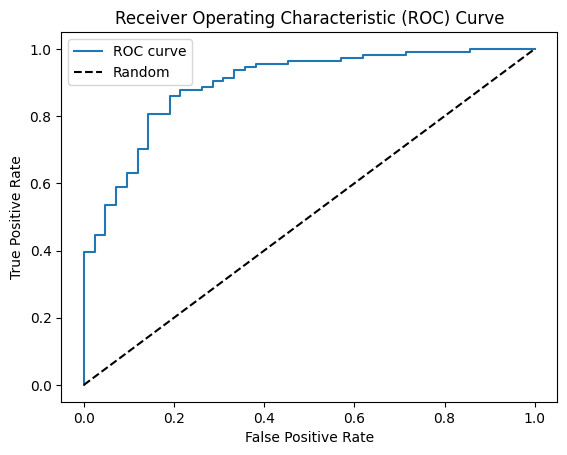

auc: 0.896, acc: 0.853


In [ ]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
train_loss, val_loss, trained_model = train(train_loader, cnn_model, optimizer, criterion, EPOCH_NUM, validation_loader)


# show training and validation curves
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# test
auc, acc = test(test_loader, trained_model,criterion)

print(f'auc: {auc:.3f}, acc: {acc:.3f}') # round both to the first 3 digits


# 3D dataset NoduleMNIST3D

Please fill the blanks in the following block to create dataloaders for training, validation, and test on 3D dataset. The visualization of each dataset is expected.

{'python_class': 'NoduleMNIST3D', 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.', 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1', 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3', 'task': 'binary-class', 'label': {'0': 'benign', '1': 'malignant'}, 'n_channels': 1, 'n_samples': {'train': 1158, 'val': 165, 'test': 310}, 'license': 'CC BY 4.0'}


100%|██████████| 29299364/29299364 [00:05<00:00, 5598890.25it/s]


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing 

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


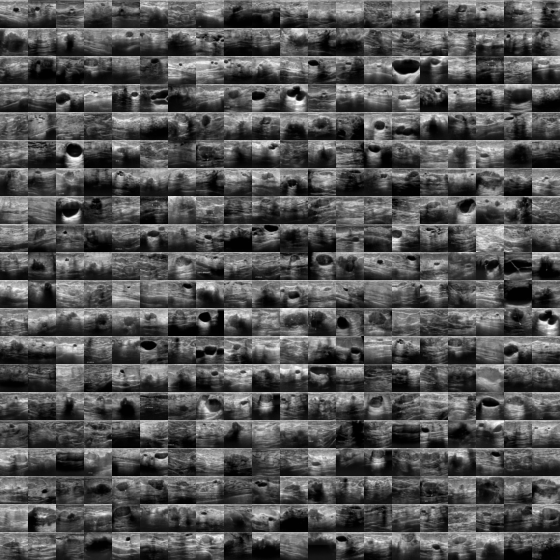

In [ ]:
# hyparameters
BATCH_SIZE =80
EPOCH_NUM =20
lr =0.00001

# dataset
data_flag_3d = 'nodulemnist3d'
download = True

info = INFO[data_flag_3d]
print(info)

task =info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# get the data class without transform
# encapsulate datasets into Dataloader form

DataClass = getattr(medmnist, info['python_class'])

train_dataset_3d = DataClass(split='train', download=download)
validation_dataset_3d = DataClass(split='val', download=download)
test_dataset_3d = DataClass(split='test', download=download)

train_loader = DataLoader(train_dataset_3d, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset_3d, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset_3d, batch_size=BATCH_SIZE, shuffle=False)

# show the details
print(train_dataset_3d)
print("===================")
print(validation_dataset_3d)
print("===================")
print(test_dataset_3d)
train_dataset.montage(length=20)

## 3D CNN implementation

Similar to what you have completed, please fill the blanks in following methods.

You expected to design a 3D CNN with 5 layers along with batch normalization and pooling.

In [ ]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=3),
            nn.BatchNorm3d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv3d(16, 16, kernel_size=3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 64, kernel_size=3),
            nn.BatchNorm3d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3),
            nn.BatchNorm3d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64*4*4*4 , 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.layer1(x.float())
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)

        return x

# initialize the 3D model
cnn3d_model = CNN_3D(in_channels=n_channels, num_classes=n_classes).to(device)

# define the BCE loss function and an optimizer you prefer
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn3d_model.parameters(), lr=lr)

# show the details
from torchsummary import summary
# SAMPLE_DATASIZE = # please pass the size of data size to SAMPLE_DATASIZE
# summary(cnn3d_model, SAMPLE_DATASIZE, BATCH_SIZE)

## Training and evaluation

Please fill empty blanks in the following block and modify the train and test functions if it is necessary. Note that train and test functions should work for both 2D CNN and 3D CNN.

Epoch [1/20], Training Loss: 0.6681239207585653, Validation Loss: 0.6845248341560364
Epoch [2/20], Training Loss: 0.5910601099332173, Validation Loss: 0.6417570114135742
Epoch [3/20], Training Loss: 0.5475532452265421, Validation Loss: 0.5760353008906046
Epoch [4/20], Training Loss: 0.5128547509511312, Validation Loss: 0.5234072407086691
Epoch [5/20], Training Loss: 0.4766381641228994, Validation Loss: 0.4829649527867635
Epoch [6/20], Training Loss: 0.448666520913442, Validation Loss: 0.4539100130399068
Epoch [7/20], Training Loss: 0.4271825353304545, Validation Loss: 0.42753905057907104
Epoch [8/20], Training Loss: 0.4064393838246663, Validation Loss: 0.4070488512516022
Epoch [9/20], Training Loss: 0.3918655296166738, Validation Loss: 0.39075485865275067
Epoch [10/20], Training Loss: 0.3740150312582652, Validation Loss: 0.37360312541325885
Epoch [11/20], Training Loss: 0.3633692463239034, Validation Loss: 0.3574202557404836
Epoch [12/20], Training Loss: 0.34978909691174825, Validation

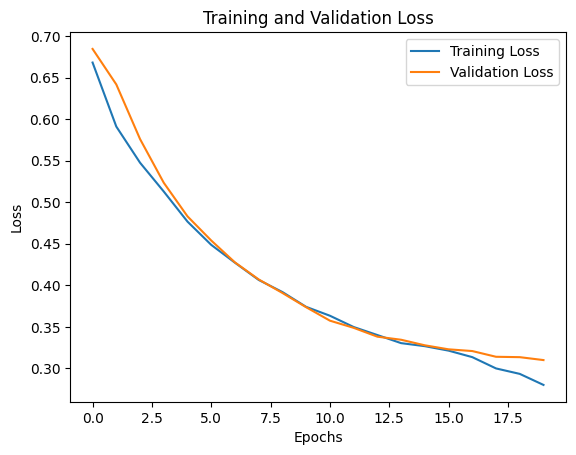

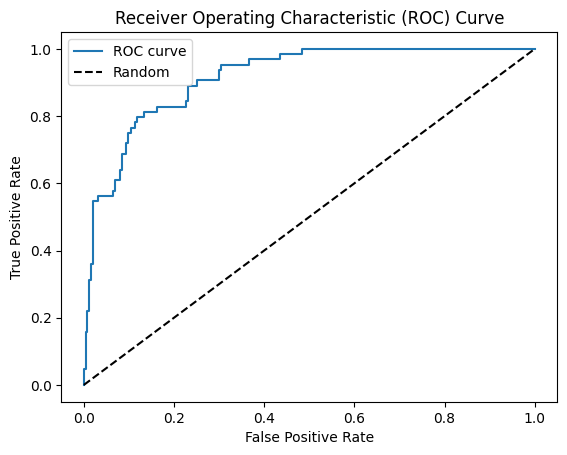

auc: 0.915, acc: 0.858


In [ ]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
train_loss, val_loss, trained_model = train(train_loader, cnn3d_model, optimizer, criterion, EPOCH_NUM, validation_loader)


# show training and validation curves
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# test
auc, acc = test(test_loader, trained_model,criterion)

print(f'auc: {auc:.3f}, acc: {acc:.3f}') # round both to the first 3 digits